# Density Plots

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pickle
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import pandas as pd

In [40]:
def densityPlotETCtracks(region, start_year, end_year, dataset, bomb=False):
    # Initialize lists to store all latitudes and longitudes
    all_lats = []
    all_lons = []

    if region == "east":
        # Define the latitude and longitude range (east)
        lon_min, lon_max = -120, -20
        lat_min, lat_max = 20, 70
    elif region == "west":
        # Define the latitude and longitude range (west)
        lon_min, lon_max = -165, -70
        lat_min, lat_max = 20, 70

    # Calculate the number of years for averaging
    num_years = end_year - start_year + 1

    # Iterate over each year and each storm to collect lat/lon data
    if dataset == "MERRA-2":
        for year in range(start_year, end_year + 1):
            with open(f"/Users/lilydonaldson/Downloads/examples/data/merra2fronts/identified_bomb_cyclones/updatedJuly9/{region}Coast/{region}_ETCs_{year}.pkl", 'rb') as f:
                data = pickle.load(f)
            for event in data:
                if bomb:
                    if event['bomb']:
                        storm_files = sorted(event['storm_files'])
                        # Extract latitude and longitude from each filename
                        for filename in storm_files:
                            parts = filename.split('_')
                            lat = float(parts[3])
                            lon = float(parts[4])
                            all_lats.append(lat)
                            all_lons.append(lon)
                else:
                    storm_files = sorted(event['storm_files'])
                    # Extract latitude and longitude from each filename
                    for filename in storm_files:
                        parts = filename.split('_')
                        lat = float(parts[3])
                        lon = float(parts[4])
                        all_lats.append(lat)
                        all_lons.append(lon)
    elif dataset == "ERA5":
        columns = [
            'Year', 'Month', 'Day', 'Hour', 'Unused1', 'lat_proxy', 'lon_proxy', 'Unused2',
            'Sea_level_pressure', 'Unused3', 'Unused4', 'Unused5', 'Unused6',
            'Unused7', 'CSI', 'USI'
        ]

        data = pd.read_csv('/Users/lilydonaldson/Downloads/out_era5_output_1950_2019.txt', delim_whitespace=True, names=columns)

        # Convert proxies to actual values
        data['Latitude'] = 90 - data['lat_proxy'] / 100
        data['Longitude'] = data['lon_proxy'] / 100
        data['Longitude'] = data['Longitude'].apply(lambda x: x - 360 if x > 90 else x)
        data['Sea_level_pressure'] = data['Sea_level_pressure'] / 1000
        for year in range(start_year, end_year + 1):
            with open(f"/Users/lilydonaldson/Downloads/examples/data/merra2fronts/identified_bomb_cyclones/updatedJuly22/{region}Coast/ERA5_ERA5ar_{region}_ETCs_{year}.pkl", 'rb') as f:
                ETCdata = pickle.load(f)

            for event in ETCdata:
                if bomb:
                    if event['bomb']:
                        storm_id = event['storm_id']

                        # Filter the data for the current storm
                        storm_data = data[data['USI'] == storm_id]

                        # Sort the data by Year, Month, Day, and Hour
                        storm_data = storm_data.sort_values(by=['Year', 'Month', 'Day', 'Hour'])

                        # Extract latitudes and longitudes
                        latitudes = storm_data['Latitude'].tolist()
                        longitudes = storm_data['Longitude'].tolist()

                        # Append lat/lon to lists
                        all_lats.extend(latitudes)
                        all_lons.extend(longitudes)
                else:
                    storm_id = event['storm_id']

                    # Filter the data for the current storm
                    storm_data = data[data['USI'] == storm_id]

                    # Sort the data by Year, Month, Day, and Hour
                    storm_data = storm_data.sort_values(by=['Year', 'Month', 'Day', 'Hour'])

                    # Extract latitudes and longitudes
                    latitudes = storm_data['Latitude'].tolist()
                    longitudes = storm_data['Longitude'].tolist()

                    # Append lat/lon to lists
                    all_lats.extend(latitudes)
                    all_lons.extend(longitudes)

    # Create a 2D histogram with 1-degree by 1-degree resolution
    lat_bins = np.arange(lat_min, lat_max + 1, 1)
    lon_bins = np.arange(lon_min, lon_max + 1, 1)
    heatmap, xedges, yedges = np.histogram2d(all_lons, all_lats, bins=[lon_bins, lat_bins], range=[[lon_min, lon_max], [lat_min, lat_max]])

    # Apply Gaussian filter to smooth the heatmap
    sigma = 1  # Standard deviation for Gaussian kernel
    smoothed_heatmap = gaussian_filter(heatmap, sigma=sigma)

    # Normalize the heatmap to get storms per year
    smoothed_heatmap_per_year = smoothed_heatmap / num_years

    # Create a custom colormap
    colors = [(1, 1, 1), (0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # white, blue, green, yellow, red
    n_bins = 100  # Discretizes the interpolation into bins
    cmap_name = 'custom_cmap'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Plotting the smoothed heatmap
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines()

    # Create the meshgrid for the heatmap
    xcenters = 0.5 * (xedges[1:] + xedges[:-1])
    ycenters = 0.5 * (yedges[1:] + yedges[:-1])
    X, Y = np.meshgrid(xcenters, ycenters)

    # Plot the heatmap with the specified color bar scale
    mesh = ax.pcolormesh(X, Y, smoothed_heatmap_per_year.T, cmap=custom_cmap, transform=ccrs.PlateCarree()) #,vmin=0, vmax=2)  # use these here to change color bar scale vmin=0, vmax=30

    # Create an axis for the colorbar on the right side of the plot, making it shorter
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar = fig.colorbar(mesh, cax=cax, orientation='vertical')
    cbar.set_label('Density of Storm Tracks (per year)')

    # Setting title and labels
    ax.set_xlim((lon_min, lon_max))
    ax.set_ylim((lat_min, lat_max))
    ax.set_xticks(ticks=np.arange(lon_min, lon_max + 1, 10))
    ax.set_yticks(ticks=np.arange(lat_min, lat_max + 1, 10))
    if bomb:
        ax.set_title(f"Density Plot of Bomb Cyclone Tracks in {dataset}, \n{start_year}-{end_year} {region.capitalize()} Coast, Smoothed: σ=1")
        plt.savefig(f"BC_track_density_{region}Coast_{dataset}_{start_year}-{end_year}.png")
    else:
        ax.set_title(f"Density Plot of ETC Tracks in {dataset}, \n{start_year}-{end_year} {region.capitalize()} Coast, Smoothed: σ=1")
        plt.savefig(f"ETC_track_density_{region}Coast_{dataset}_{start_year}-{end_year}.png")
    plt.show()

# Example usage:
# densityPlotETCtracks('east', 1950, 2023, 'ERA5', bomb=True)


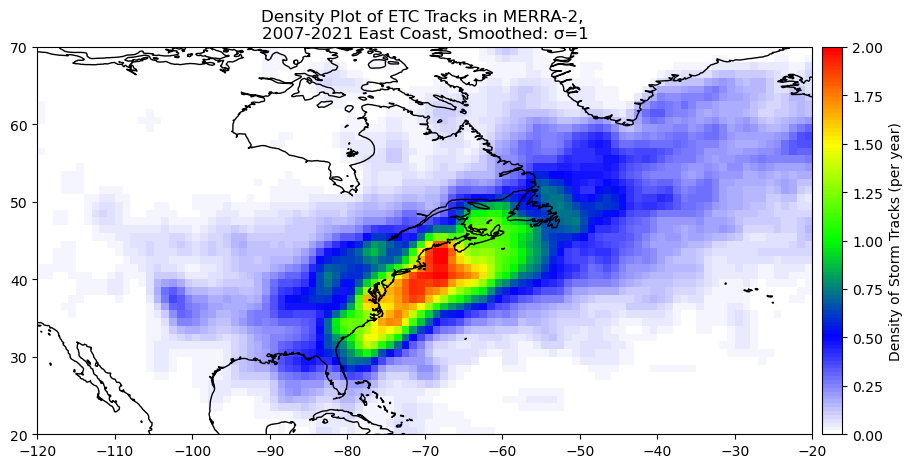

In [39]:
region = 'east' #west or east usa coast region
start_year = 2007
end_year = 2021
dataset = "MERRA-2" #MERRA-2 or ERA5
bomb = False #set this to True if you only want to plot bomb cyclones in the dataset, otherwise function will plot all ETCs
densityPlotETCtracks(region, start_year, end_year, dataset, bomb)

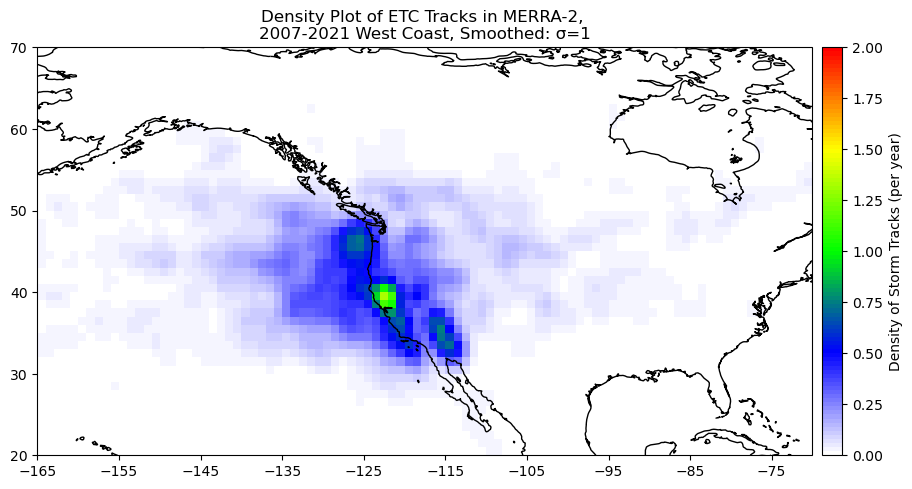

In [29]:
region = 'west' #west or east usa coast region
start_year = 2007
end_year = 2021
dataset = "MERRA-2" #MERRA-2 or ERA5
bomb = False #set this to True if you only want to plot bomb cyclones in the dataset, otherwise function will plot all ETCs
densityPlotETCtracks(region, start_year, end_year, dataset, bomb)

/var/folders/3x/6dh1l7m535n5hvm8c7tjlk_00000gn/T/ipykernel_70581/1587695926.py:50: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('/Users/lilydonaldson/Downloads/out_era5_output_1950_2019.txt', delim_whitespace=True, names=columns)


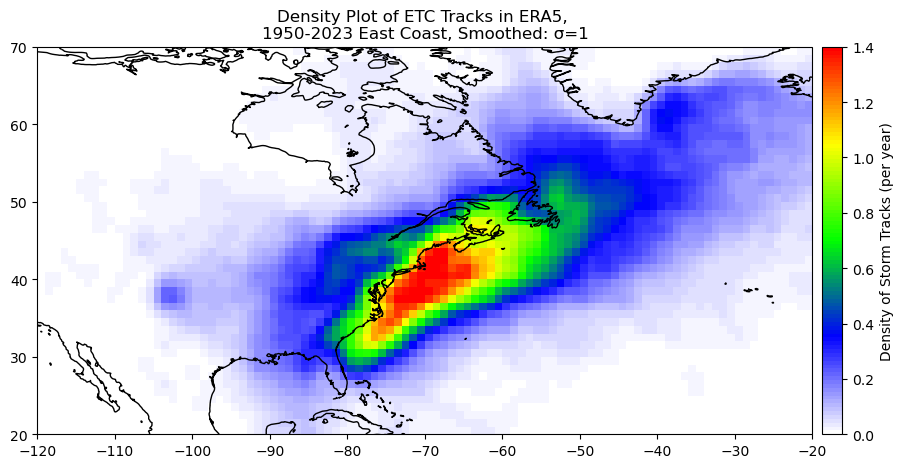

In [35]:
region = 'east' #west or east usa coast region
start_year = 1950
end_year = 2023
dataset = "ERA5" #MERRA-2 or ERA5
bomb = False #set this to True if you only want to plot bomb cyclones in the dataset, otherwise function will plot all ETCs
densityPlotETCtracks(region, start_year, end_year, dataset, bomb)

/var/folders/3x/6dh1l7m535n5hvm8c7tjlk_00000gn/T/ipykernel_70581/1587695926.py:50: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('/Users/lilydonaldson/Downloads/out_era5_output_1950_2019.txt', delim_whitespace=True, names=columns)


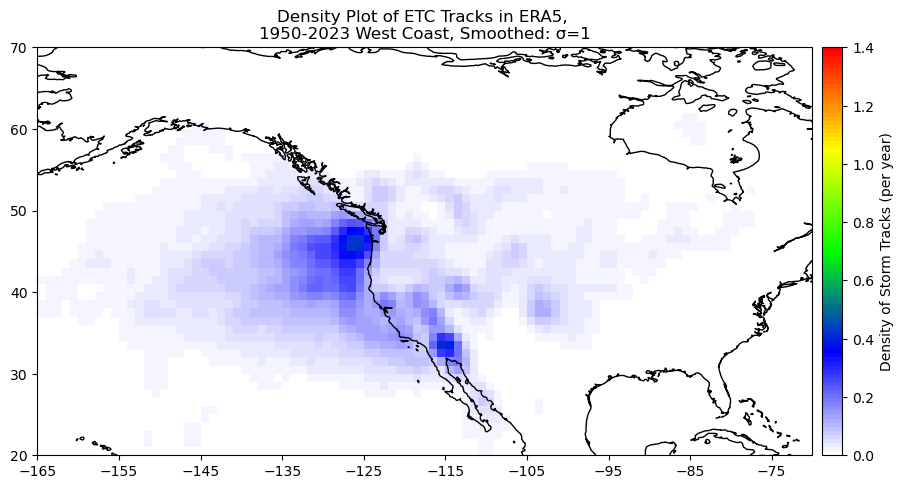

In [36]:
region = 'west' #west or east usa coast region
start_year = 1950
end_year = 2023
dataset = "ERA5" #MERRA-2 or ERA5
bomb = False #set this to True if you only want to plot bomb cyclones in the dataset, otherwise function will plot all ETCs
densityPlotETCtracks(region, start_year, end_year, dataset, bomb)

/var/folders/3x/6dh1l7m535n5hvm8c7tjlk_00000gn/T/ipykernel_70581/1283734096.py:50: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('/Users/lilydonaldson/Downloads/out_era5_output_1950_2019.txt', delim_whitespace=True, names=columns)


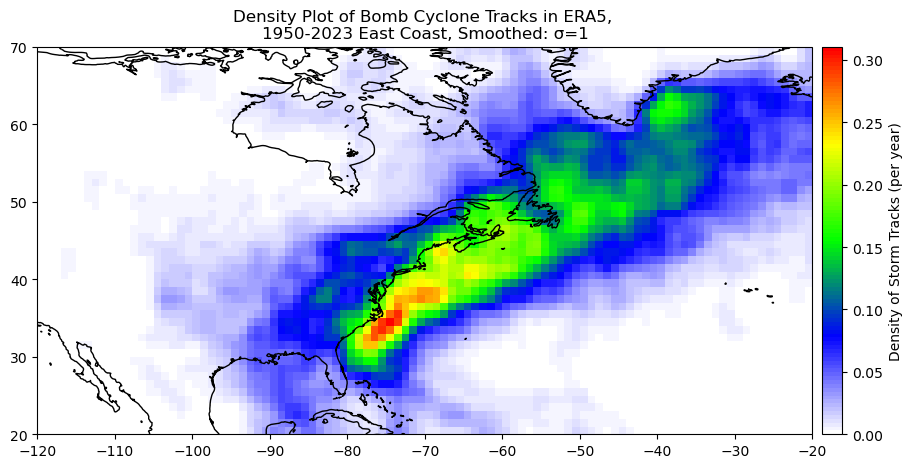

In [41]:
region = 'east' #west or east usa coast region
start_year = 1950
end_year = 2023
dataset = "ERA5" #MERRA-2 or ERA5
bomb = True #set this to True if you only want to plot bomb cyclones in the dataset, otherwise function will plot all ETCs
densityPlotETCtracks(region, start_year, end_year, dataset, bomb)

# Storm Track Plots

In [47]:
def plot_storm_tracks(start_year, end_year,region):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines()
    
    for year in range(start_year, end_year + 1):
        with open(f"/Users/lilydonaldson/Downloads/examples/data/merra2fronts/identified_bomb_cyclones/updatedJuly9/{region}Coast/{region}_ETCs_{year}.pkl", 'rb') as f:
            data = pickle.load(f)
        
        for event in data:
            if event['bomb']: 
                if event['bomb_in_mask']: 
                    storm_files = sorted(event['storm_files'])
                    start_file = event['bomb_start_file']
                    end_file = event['bomb_end_file']
        
                    # Find indices for the start and end files in the sorted list
                    start_index = storm_files.index(start_file)
                    end_index = storm_files.index(end_file) + 1  # +1 to include the end file in the slice
        
                    # Extract lat/lon for only the relevant segment of storm_files
                    lat_lon_list = []
                    for filename in storm_files[start_index:end_index]:
                        parts = filename.split('_')
                        lat = float(parts[3])
                        lon = float(parts[4])
                        lat_lon_list.append((lon, lat))
        
                    # Plotting the segment for the current bomb cyclone
                    if lat_lon_list:  # Ensure there are points to plot
                        lons, lats = zip(*lat_lon_list)
                        if(event['AR_bomb_concurrent']):
                            ax.plot(lons, lats, color=('red'), alpha=0.2)
                        else:
                            ax.plot(lons, lats, color=('blue'), alpha=0.2)
    
    ax.set_xlim((-120, -20))
    ax.set_ylim((20, 70))
    ax.set_xticks(ticks=[-120, -100, -80, -60, -40, -20])
    ax.set_yticks(ticks=[20, 30, 40, 50, 60, 70])
    ax.set_title(f"All Bomb Cyclone Bombogenesis Tracks (MERRA-2), {start_year}-{end_year} {region.capitalize()} Coast\nAR-concurrent tracks red, non-AR-concurrent tracks blue")
    plt.savefig("/Users/lilydonaldson/Downloads/bomb_tracks.png")
    plt.show()


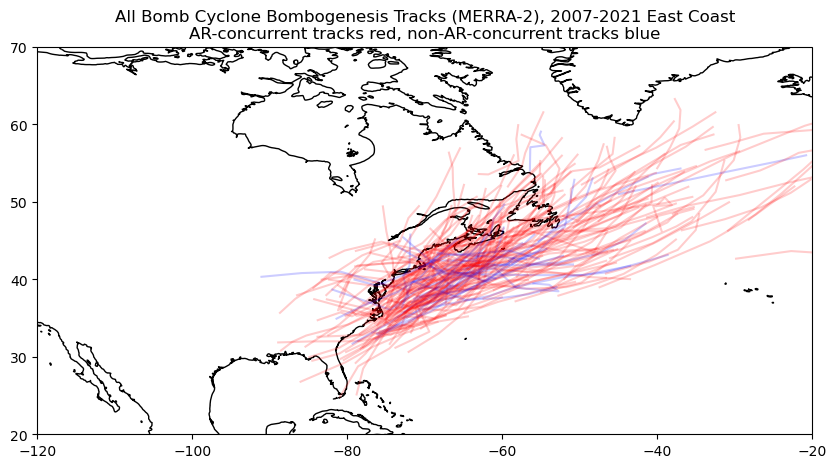

In [48]:
region = 'east' #west or east usa coast region
start_year = 2007
end_year = 2021
plot_storm_tracks(start_year, end_year,region)